In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
file_path = "C:/Users/samar/OneDrive/Desktop/mathapp/APST/dataChallenge"

In [3]:
away_player_train = file_path + "/Train_Data/train_away_player_statistics_df.csv"
away_team_train = file_path + "/Train_Data/train_away_team_statistics_df.csv"
home_player_train = file_path + "/Train_Data/train_home_player_statistics_df.csv"
home_team_train = file_path + "/Train_Data/train_home_team_statistics_df.csv"

In [4]:
away_player_test = file_path + "/Test_Data/test_away_player_statistics_df.csv"
away_team_test = file_path + "/Test_Data/test_away_team_statistics_df.csv"
home_player_test = file_path + "/Test_Data/test_home_player_statistics_df.csv"
home_team_test = file_path + "/Test_Data/test_home_team_statistics_df.csv"

In [5]:
Y_train_supp = file_path + "/benchmark_and_extras/Y_train_supp.csv"
Y_train = file_path + "/Y_train.csv"
Y_test_random = file_path + "/Y_test_random.csv"

Challenge context

Over the last two decades, professional sports around the world have adapted towards a data-driven approach to their decision-making. Sports analytics are part of live broadcasts, fantasy sports, and every-day discussions. This growth has been fueled by an exponential evolution in sports data.

Data science and machine learning can be useful to tackle the growing field of sports analytics. It can be used by fantasy league players and professional gamblers alike to make better informed decisions. Sports betting websites have become quite sophisticated in this area in the last few years. Models can also be used by managers of professional sports teams and recruiters to build rosters and strategically deploy players in a way that increases the team’s chance of winning.

Football has been at the heart of the sports analytics revolution. All types of statistics, both historical and real-time, are available. This challenge leverages Football data obtained from Sportmonks, a top-tier sports data provider widely used to enhance various online applications and websites. For additional details, feel free to explore sportmonks.com.

Feel free to visit and register to our dedicated forum at challengedata.qube-rt.com for more information about the challenge, the data and QRT.

Challenge goals

As this year’s QRT data challenge, we propose a match result prediction challenge. You will be provided with real historical data at the player, team and league level, and be asked to predict which team wins, or if there is a draw.

We have data for many leagues around the world and at different divisions. Your goal is to build a rich predictive models that can work in any football league regardless of competitive level or geographical location.

Data description

We provide data at the team and player level for dozens of football leagues.

The data comes packed in two zip files, X_train.zip, and X_test.zip, as well as two csv files Y_train.csv, and Y_train_supp.csv

The zip files contain the input data, which is divided into 4 csv files. The data is separated into HOME and AWAY team statistics, which is aggregated at the team and player level. All statistics come from real historical matches. They are summaries of the last 5 games prior to the match, as well as season-to-date statistics of the game being predicted.

The ID column links tables in X_train, with Y_train and Y_train_supp. The same holds true for the test data.

Input team data sets comprise the following 3 identifier columns:

ID, LEAGUE and TEAM_NAME (note that LEAGUE and TEAM_NAME are not included in the test data)
The following 25 statistics, which are aggregated by sum, average and standard deviation.

'TEAM_ATTACKS'
'TEAM_BALL_POSSESSION'
'TEAM_BALL_SAFE'
'TEAM_CORNERS'
'TEAM_DANGEROUS_ATTACKS'
'TEAM_FOULS'
'TEAM_GAME_DRAW'
'TEAM_GAME_LOST'
'TEAM_GAME_WON'
'TEAM_GOALS'
'TEAM_INJURIES'
'TEAM_OFFSIDES'
'TEAM_PASSES'
'TEAM_PENALTIES'
'TEAM_REDCARDS'
'TEAM_SAVES'
'TEAM_SHOTS_INSIDEBOX'
'TEAM_SHOTS_OFF_TARGET'
'TEAM_SHOTS_ON_TARGET',
'TEAM_SHOTS_OUTSIDEBOX'
'TEAM_SHOTS_TOTAL'
'TEAM_SUBSTITUTIONS'
'TEAM_SUCCESSFUL_PASSES'
'TEAM_SUCCESSFUL_PASSES_PERCENTAGE'
'TEAM_YELLOWCARDS'
Input player data sets comprise the following 3 identifier columns:

ID, LEAGUE and TEAM_NAME, POSITION and PLAYER_NAME (note that LEAGUE, TEAM_NAME, and PLAYER_NAME are not included in the test data)
52 statistics, which are aggregated by sum, average and standard deviation. They are similar to the team statistics though more fine-grained.

Output data sets are composed of 4 columns:

ID: Unique row identifier - corresponding to the input identifiers,
HOME_WINS,
DRAW,
AWAY_WINS,
The target score is the accuracy of prediction for the vector [HOME_WINS, DRAW,AWAY_WINS], for which there are three possible choices, [1,0,0]. [0,1,0] and [0,0,1].

All variables have been standardized and team/players/and league names have been removed from the test set. We have provided as much data in the train set as possible for your convenience. We expect from you to not use any external data, which can lead to disqualification.

An example of submission file containing random predictions is provided - see also the notebook in the supplementary material section for the benchmark output.

We have included other alternate training targets, such as GOAL_DIFF_HOME_AWAY, which is the difference of goals between the HOME and AWAY team, in the Y_train_supp file in case you want to train richer models with different targets.

Disclaimer: The data provided is exclusively intended for use in this challenge, and any usage of this dataset for other purposes is strictly prohibited. General terms or service are applicable: terms of service

## Read  team train data

In [6]:
#Read  team train data

train_home_team_statistics_df = pd.read_csv(home_team_train, index_col=0)
train_away_team_statistics_df = pd.read_csv(away_team_train, index_col=0)

train_scores = pd.read_csv(Y_train, index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

In [7]:
train_home_team_statistics_df.head()

,LEAGUE,TEAM_NAME,TEAM_SHOTS_TOTAL_season_sum,TEAM_SHOTS_INSIDEBOX_season_sum,TEAM_SHOTS_OFF_TARGET_season_sum,TEAM_SHOTS_ON_TARGET_season_sum,TEAM_SHOTS_OUTSIDEBOX_season_sum,TEAM_PASSES_season_sum,TEAM_SUCCESSFUL_PASSES_season_sum,TEAM_SAVES_season_sum,...,TEAM_YELLOWCARDS_5_last_match_std,TEAM_REDCARDS_5_last_match_std,TEAM_OFFSIDES_5_last_match_std,TEAM_ATTACKS_5_last_match_std,TEAM_PENALTIES_5_last_match_std,TEAM_SUBSTITUTIONS_5_last_match_std,TEAM_BALL_SAFE_5_last_match_std,TEAM_DANGEROUS_ATTACKS_5_last_match_std,TEAM_INJURIES_5_last_match_std,TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,Ligue 1,Toulouse,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,...,3.0,0.0,6.0,0.0,10.0,8.0,7.0,2.0,4.0,3.0
1,Ligue 2,Brest,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,...,4.0,0.0,4.0,3.0,10.0,0.0,1.0,2.0,8.0,4.0
2,Serie A,Sampdoria,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,...,4.0,5.0,6.0,3.0,6.0,7.0,2.0,3.0,2.0,4.0
3,League One,Coventry City,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,...,4.0,0.0,1.0,8.0,8.0,5.0,5.0,5.0,NaN,6.0
4,Premier League,Wolverhampton Wanderers,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,...,1.0,0.0,2.0,5.0,8.0,7.0,2.0,6.0,4.0,4.0


In [8]:
train_data.head()

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,6.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,8.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,7.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,0.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,NaN,2.0
4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0


In [9]:
train_scores.head()

,HOME_WINS,DRAW,AWAY_WINS
ID,,,
0,0,0,1
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0


## Read player train data

In [10]:

home_players = pd.read_csv(home_player_train)
away_players = pd.read_csv(away_player_train)

# team_name and league and player_name are not included in the test dataset so no need to use it
home_players = home_players.drop(columns=['TEAM_NAME', 'LEAGUE', 'PLAYER_NAME'])
away_players = away_players.drop(columns=['TEAM_NAME', 'LEAGUE', 'PLAYER_NAME'])

home_players['POSITION'] = home_players['POSITION'].replace({'defender': 1, 'midfielder': 2, 'attacker': 3, 'goalkeeper': 4, '': 0, np.nan: 0})
away_players['POSITION'] = away_players['POSITION'].replace({'defender': 1, 'midfielder': 2, 'attacker': 3, 'goalkeeper': 4, '': 0, np.nan: 0})

In [ ]:
# Aggregate player stats by ID and POSITION 
home_team_stats = home_players.groupby(by = ['ID', 'POSITION'], as_index= False).mean().fillna(0)
away_team_stats = away_players.groupby(by = ['ID', 'POSITION'], as_index= False).mean().fillna(0)

team_comparison = pd.merge(home_team_stats, away_team_stats, on=['ID', 'POSITION'], suffixes=('_home', '_away'))


In [12]:
team_comparison.head()

,ID,POSITION,PLAYER_ACCURATE_CROSSES_season_sum_home,PLAYER_ACCURATE_PASSES_season_sum_home,PLAYER_AERIALS_WON_season_sum_home,PLAYER_ASSISTS_season_sum_home,PLAYER_BIG_CHANCES_CREATED_season_sum_home,PLAYER_BIG_CHANCES_MISSED_season_sum_home,PLAYER_BLOCKED_SHOTS_season_sum_home,PLAYER_CAPTAIN_season_sum_home,...,PLAYER_STARTING_LINEUP_5_last_match_std_away,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std_away,PLAYER_TACKLES_5_last_match_std_away,PLAYER_TOTAL_CROSSES_5_last_match_std_away,PLAYER_TOTAL_DUELS_5_last_match_std_away,PLAYER_YELLOWCARDS_5_last_match_std_away,PLAYER_PUNCHES_5_last_match_std_away,PLAYER_LONG_BALLS_5_last_match_std_away,PLAYER_LONG_BALLS_WON_5_last_match_std_away,PLAYER_SHOTS_OFF_TARGET_5_last_match_std_away
0,0,0.0,3.25,12.000000,21.250000,10.500000,6.000000,21.500000,3.000000,0.0,...,36.166667,26.000000,21.000000,25.833333,35.333333,38.5,0.0,0.0,0.0,0.0
1,0,1.0,4.00,27.166667,22.166667,7.000000,5.333333,0.000000,17.500000,0.0,...,17.500000,36.250000,40.000000,17.750000,42.250000,67.5,0.0,0.0,0.0,0.0
2,0,2.0,24.50,23.333333,9.166667,9.333333,12.333333,4.166667,8.166667,45.5,...,28.000000,17.800000,26.200000,9.000000,33.400000,34.2,0.0,0.0,0.0,0.0
3,0,4.0,0.00,16.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,7.000000,0.000000,0.000000,2.000000,0.0,0.0,0.0,0.0,0.0
4,1,0.0,4.00,12.333333,13.000000,40.000000,20.666667,32.666667,2.666667,0.0,...,72.333333,16.666667,6.666667,12.333333,34.666667,0.0,0.0,0.0,0.0,0.0


In [13]:
for column_name in team_comparison.columns:
    if column_name.endswith('_home'):  # Ensure we're processing only '_home' columns
        prefix = column_name[:-5]  # Remove '_home' to get the base column name
        team_comparison[prefix + '_diff'] = (
            team_comparison[column_name] - team_comparison[prefix + '_away']
        )

In [14]:

team_comparison.head()

,ID,POSITION,PLAYER_ACCURATE_CROSSES_season_sum_home,PLAYER_ACCURATE_PASSES_season_sum_home,PLAYER_AERIALS_WON_season_sum_home,PLAYER_ASSISTS_season_sum_home,PLAYER_BIG_CHANCES_CREATED_season_sum_home,PLAYER_BIG_CHANCES_MISSED_season_sum_home,PLAYER_BLOCKED_SHOTS_season_sum_home,PLAYER_CAPTAIN_season_sum_home,...,PLAYER_STARTING_LINEUP_5_last_match_std_diff,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std_diff,PLAYER_TACKLES_5_last_match_std_diff,PLAYER_TOTAL_CROSSES_5_last_match_std_diff,PLAYER_TOTAL_DUELS_5_last_match_std_diff,PLAYER_YELLOWCARDS_5_last_match_std_diff,PLAYER_PUNCHES_5_last_match_std_diff,PLAYER_LONG_BALLS_5_last_match_std_diff,PLAYER_LONG_BALLS_WON_5_last_match_std_diff,PLAYER_SHOTS_OFF_TARGET_5_last_match_std_diff
0,0,0.0,3.25,12.000000,21.250000,10.500000,6.000000,21.500000,3.000000,0.0,...,33.833333,-10.500000,-12.000000,-15.583333,5.416667,0.000000,0.0,0.0,0.0,0.0
1,0,1.0,4.00,27.166667,22.166667,7.000000,5.333333,0.000000,17.500000,0.0,...,10.500000,-16.850000,-9.000000,-5.150000,-0.050000,12.900000,0.0,0.0,0.0,0.0
2,0,2.0,24.50,23.333333,9.166667,9.333333,12.333333,4.166667,8.166667,45.5,...,5.833333,23.866667,13.800000,15.333333,14.766667,-8.533333,0.0,0.0,0.0,0.0
3,0,4.0,0.00,16.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,-7.000000,0.000000,0.000000,-0.500000,0.000000,0.0,0.0,0.0,0.0
4,1,0.0,4.00,12.333333,13.000000,40.000000,20.666667,32.666667,2.666667,0.0,...,-72.333333,-9.000000,-2.666667,-7.333333,-16.000000,0.000000,0.0,0.0,0.0,0.0


In [15]:
# give weight to some positions

In [16]:
# Load labels
labels = pd.read_csv(Y_train)

# Merge with features
data_with_labels = pd.merge(team_comparison, labels, how='right', on='ID')

In [17]:
data_with_labels.head()

,ID,POSITION,PLAYER_ACCURATE_CROSSES_season_sum_home,PLAYER_ACCURATE_PASSES_season_sum_home,PLAYER_AERIALS_WON_season_sum_home,PLAYER_ASSISTS_season_sum_home,PLAYER_BIG_CHANCES_CREATED_season_sum_home,PLAYER_BIG_CHANCES_MISSED_season_sum_home,PLAYER_BLOCKED_SHOTS_season_sum_home,PLAYER_CAPTAIN_season_sum_home,...,PLAYER_TOTAL_CROSSES_5_last_match_std_diff,PLAYER_TOTAL_DUELS_5_last_match_std_diff,PLAYER_YELLOWCARDS_5_last_match_std_diff,PLAYER_PUNCHES_5_last_match_std_diff,PLAYER_LONG_BALLS_5_last_match_std_diff,PLAYER_LONG_BALLS_WON_5_last_match_std_diff,PLAYER_SHOTS_OFF_TARGET_5_last_match_std_diff,HOME_WINS,DRAW,AWAY_WINS
0,0,0.0,3.25,12.000000,21.250000,10.500000,6.000000,21.500000,3.000000,0.0,...,-15.583333,5.416667,0.000000,0.0,0.0,0.0,0.0,0,0,1
1,0,1.0,4.00,27.166667,22.166667,7.000000,5.333333,0.000000,17.500000,0.0,...,-5.150000,-0.050000,12.900000,0.0,0.0,0.0,0.0,0,0,1
2,0,2.0,24.50,23.333333,9.166667,9.333333,12.333333,4.166667,8.166667,45.5,...,15.333333,14.766667,-8.533333,0.0,0.0,0.0,0.0,0,0,1
3,0,4.0,0.00,16.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,-0.500000,0.000000,0.0,0.0,0.0,0.0,0,0,1
4,1,0.0,4.00,12.333333,13.000000,40.000000,20.666667,32.666667,2.666667,0.0,...,-7.333333,-16.000000,0.000000,0.0,0.0,0.0,0.0,0,1,0


In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split data
X = data_with_labels.drop(['HOME_WINS', 'DRAW', 'AWAY_WINS'], axis=1).fillna(0)
y = data_with_labels[['HOME_WINS', 'DRAW', 'AWAY_WINS']].values.argmax(axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
y_train

array([2, 0, 1, ..., 0, 1, 0])

### Gradient Boosting Classifier

In [88]:
# Train model # Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.4845036844386649


In [89]:
y_pred

array([0, 2, 0, ..., 2, 2, 2])

find imporatance of the features

Position Feature Importance:
    Feature  Importance
1  POSITION    0.000657
Top 10 Most Important Features:
                                               Feature  Importance
676          PLAYER_GOALS_CONCEDED_season_average_diff    0.228651
657  PLAYER_ACCURATE_PASSES_PERCENTAGE_season_avera...    0.066354
656         PLAYER_ACCURATE_PASSES_season_average_diff    0.035514
727              PLAYER_GOALS_CONCEDED_season_std_diff    0.033241
0                                                   ID    0.025598
607             PLAYER_ACCURATE_PASSES_season_sum_diff    0.021111
661      PLAYER_BIG_CHANCES_MISSED_season_average_diff    0.017765
664              PLAYER_CLEARANCES_season_average_diff    0.016324
660     PLAYER_BIG_CHANCES_CREATED_season_average_diff    0.015921
609                     PLAYER_ASSISTS_season_sum_diff    0.014163


<Axes: title={'center': 'Feature Importances'}, xlabel='Feature'>

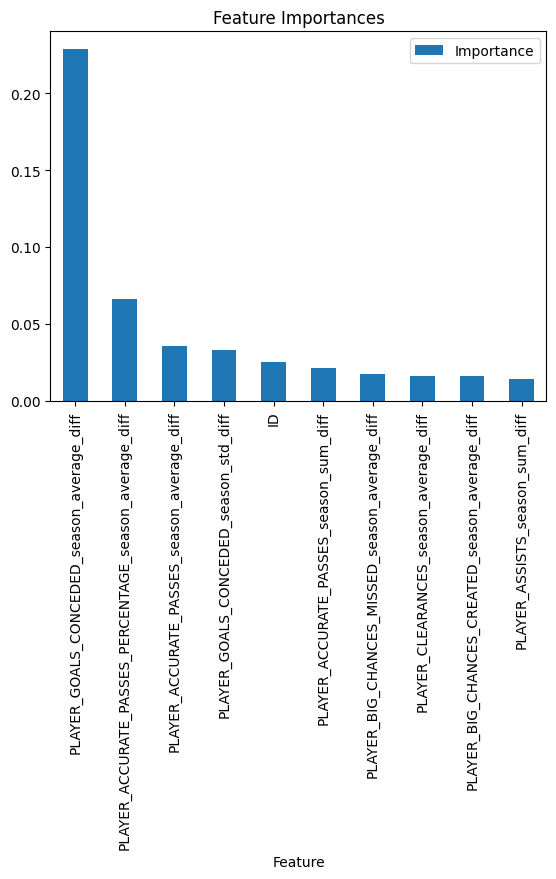

In [90]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to map feature names to importances
feature_names = X_train.columns  # Ensure column names match the dataset
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance for better visualization
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Display importance of 'POSITION'
position_importance = importances_df[importances_df['Feature'] == 'POSITION']
print("Position Feature Importance:")
print(position_importance)

# Display the top 10 features
top_features = importances_df.head(10)
print("Top 10 Most Important Features:")
print(top_features)

# Optional: Visualize the importances
top_features.plot(kind='bar', x='Feature', y='Importance', title="Feature Importances")

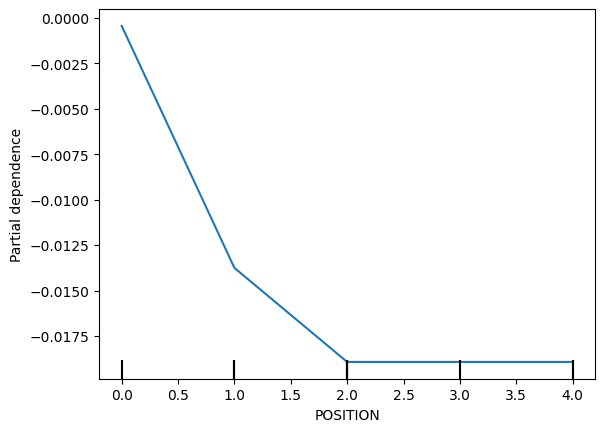

In [91]:
#Partial Dependence Plot (PDP) show how predictions change as the POSITION feature varies
from sklearn.inspection import PartialDependenceDisplay

# Plot PDP for the 'POSITION' feature for the first class (e.g., HOME_WINS)
PartialDependenceDisplay.from_estimator(model, X_train, ['POSITION'], grid_resolution=20, target=0)

In [ ]:
#Calculate Weights
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0, 1, 2, 3, 4])
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=X_train['POSITION'] 
)

class_weights = dict(zip(classes, weights))
print("Class Weights:", class_weights)

Class Weights: {np.int64(0): np.float64(1.4064393217755764), np.int64(1): np.float64(0.8277161116717121), np.int64(2): np.float64(0.8240205380064739), np.int64(3): np.float64(1.580813704496788), np.int64(4): np.float64(0.8099177180471749)}


In [96]:
#Incorporate Weights into the Model:
# Add sample weights based on POSITION
sample_weights = X_train['POSITION'].map(class_weights)

# Fit the model using sample weights
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train.drop(columns=['POSITION']), y_train, sample_weight=sample_weights)
y_pred = model.predict(X_val.drop(columns=['POSITION']))
print("Accuracy with Weights:", accuracy_score(y_val, y_pred))

Accuracy with Weights: 0.4827698309492848


In [97]:
#SHAP values can explain the influence of each feature (and its values) on individual predictions.
import shap

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Visualize for 'POSITION'
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

ModuleNotFoundError: No module named 'shap'

##### improve the model

In [ ]:
# Use GridSearchCV to find optimal hyperparameters:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Params:", grid_search.best_params_)
model = grid_search.best_estimator_

KeyboardInterrupt: 

In [ ]:
# Implement cross-validation for better evaluation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", cv_scores.mean())

In [98]:
#Ensure consistent scaling for feature

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.4845036844386649


In [99]:
#Use SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
#Reduce noise by selecting relevant features

from sklearn.feature_selection import SelectFromModel

feature_selector = SelectFromModel(model, threshold='median')
X_train_selected = feature_selector.fit_transform(X_train, y_train)
X_val_selected = feature_selector.transform(X_val)

model.fit(X_train_selected, y_train)
y_pred = model.predict(X_val_selected)
print("Accuracy with Feature Selection:", accuracy_score(y_val, y_pred))

In [ ]:
#Use early stopping to avoid overfitting
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42,
    validation_fraction=0.1,
    n_iter_no_change=10
)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))

### XGBClassifier

Highly efficient for tabular data and supports multi-class classification. Offers regularization for better generalization.

In [ ]:
# Optimize Model Parameters 
from sklearn.model_selection import GridSearchCV
import xgboost

param_grid = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.025, 0.05],
    'n_estimators': [500, 1000],
    'colsample_bytree': [0.6, 0.8],
    'subsample': [0.8, 1.0],
}
grid_search = GridSearchCV(xgboost.XGBClassifier(objective='multi:softprob', num_class=3), param_grid, cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

In [86]:
params_1 = {
    'max_depth': 10,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'colsample_bytree': 0.8,
    'subsample': 1.0,
}
modelXGB = xgb.XGBClassifier(params_1)
modelXGB.fit(X_train, y_train)

# Evaluate
y_pred = modelXGB.predict(X_val) 
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.4710663198959688


### Random Forest Classifier

Captures non-linear relationships and works well with feature importance analysis.

In [189]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_preds)
print("Accuracy:", rf_accuracy)

Accuracy: 0.4755093194625054


In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)
grid_search_rf.fit(X_train, y_train)
print(f"Best Random Forest Params: {grid_search_rf.best_params_}")

Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [36]:
# Random Forest Classifier
rf_model_improved = RandomForestClassifier(n_estimators= 100, random_state= 42, max_depth= 10, min_samples_split= 2)
rf_model_improved.fit(X_train, y_train)
rf_preds = rf_model_improved.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_preds)
print("Accuracy:", rf_accuracy)

Accuracy: 0.4822280017338535


In [37]:
rf_preds

array([0, 2, 0, ..., 2, 2, 0])

### Logistic Regression

Simple and interpretable, suitable if the relationships are mostly linear.

In [70]:
from sklearn.linear_model import LogisticRegression
model_logistic_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
model_logistic_reg.fit(X_train, y_train)
y_pred = model_logistic_reg.predict(X_val)

In [27]:
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.47919375812743825


### Neural Networks

Effective if your dataset is large and complex. Can model interactions between features that traditional models might miss.

In [28]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.39434330299089726


###  Ensemble Methods

Combine predictions from multiple models (e.g., Random Forest + Gradient Boosting) to improve robustness.

In [30]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(random_state=42)
model2 = GradientBoostingClassifier(random_state=42)
ensemble = VotingClassifier(estimators=[('rf', model1), ('gb', model2)], voting='soft')
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.48255309926311224


### Support Vector Machine (SVM)

Effective for smaller datasets with clear class boundaries but may not scale well.

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
svm_preds = svm_model.predict(X_val)

# Evaluate the model
svm_accuracy = accuracy_score(y_val, svm_preds)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.4359557867360208


### CatBoost

Handles categorical features without requiring one-hot encoding and is robust for tabular data.

In [32]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Initialize the CatBoost model
catboost_model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0)

# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions
catboost_preds = catboost_model.predict(X_val)

# Evaluate the model
catboost_accuracy = accuracy_score(y_val, catboost_preds)
print("CatBoost Accuracy:", catboost_accuracy)

ModuleNotFoundError: No module named 'catboost'

### K-Nearest Neighbors (KNN)

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions
knn_preds = knn_model.predict(X_val)

# Evaluate the model
knn_accuracy = accuracy_score(y_val, knn_preds)
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.41211530125704376


#### Submission

In [39]:
home_players_test = pd.read_csv(home_player_test)
away_players_test = pd.read_csv(away_player_test)

num_distinct_ids = home_players_test['ID'].nunique()
num_distinct_ids1 = away_players_test['ID'].nunique()
print(num_distinct_ids, num_distinct_ids1)

25368 25368


In [40]:
home_players_test['POSITION'] = home_players_test['POSITION'].replace({'defender': 1, 'midfielder': 2, 'attacker': 3, 'goalkeeper': 4, '': 0, np.nan: 0})
away_players_test['POSITION'] = away_players_test['POSITION'].replace({'defender': 1, 'midfielder': 2, 'attacker': 3, 'goalkeeper': 4, '': 0, np.nan: 0})

num_distinct_ids2 = home_players_test['ID'].nunique()
num_distinct_ids3 = away_players_test['ID'].nunique()
print(num_distinct_ids2, num_distinct_ids3)

25368 25368


In [57]:
# Aggregate player stats by ID and POSITION 
home_team_stats = home_players_test.groupby(by = ['ID', 'POSITION'], as_index=False).mean()
away_team_stats = away_players_test.groupby(by = ['ID', 'POSITION'], as_index=False).mean()

In [75]:
# Merge on match ID and POSITION
team_comparison_test = pd.merge(home_team_stats, away_team_stats, on=['ID', 'POSITION'], suffixes=('_home', '_away'), how='outer').fillna(0)

In [76]:
for column_name in team_comparison_test.columns:
    if column_name.endswith('_home'):  # Ensure we're processing only '_home' columns
        prefix = column_name[:-5]  # Remove '_home' to get the base column name
        team_comparison_test[prefix + '_diff'] = (
            team_comparison_test[column_name] - team_comparison_test[prefix + '_away']
        )


#### Gradient Boosting submission

In [63]:
GB_predictions = model.predict(team_comparison_test)
team_comparison_test.set_index('ID', inplace=True)

In [64]:
predictions_sub = np.zeros((GB_predictions.size, 3))
for i in range(GB_predictions.size):
    predictions_sub[i][GB_predictions[i]] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = team_comparison_test.index
submissionGB = predictions_sub.reset_index()
submissionGB = submissionGB.groupby('ID').sum().div(4).round().astype(int).reset_index()
submissionGB

,ID,HOME_WINS,DRAW,AWAY_WINS
0,12303,0,0,0
1,12304,0,0,1
2,12305,0,0,0
3,12306,0,1,0
4,12307,0,1,0
...,...,...,...,...
25363,37666,0,1,0
25364,37667,0,0,1
25365,37668,0,1,0
25366,37669,0,0,1


In [65]:
submissionGB.to_csv(file_path + "/submission_gb.csv", index=False)

#### RF Submission

In [ ]:
RF_predictions = rf_model_improved.predict(team_comparison_test)
RF_predictions

array([0, 2, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
team_comparison_test.set_index('ID', inplace=True)
team_comparison_test.head()

(91163, 907)

In [ ]:
predictions_sub = np.zeros((RF_predictions.size, 3))
for i in range(RF_predictions.size):
    predictions_sub[i][RF_predictions[i]] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = team_comparison_test.index
submission = predictions_sub.reset_index()
submission = submission.groupby('ID').sum().div(4).round().astype(int).reset_index()
submission

,ID,HOME_WINS,DRAW,AWAY_WINS
0,12303,1,0,0
1,12304,1,0,0
2,12305,1,0,0
3,12306,1,0,0
4,12307,0,0,0
...,...,...,...,...
25363,37666,0,0,0
25364,37667,0,0,0
25365,37668,1,0,0
25366,37669,1,0,0


In [ ]:
submission.to_csv(file_path + "/submission_rf.csv", index=False)

#### Logistic Regression submission

In [71]:
y_pred = model_logistic_reg.predict(team_comparison_test)
team_comparison_test.set_index('ID', inplace=True)
team_comparison_test.head()
predictions_sub = np.zeros((y_pred.size, 3))
for i in range(y_pred.size):
    predictions_sub[i][y_pred[i]] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = team_comparison_test.index
submission = predictions_sub.reset_index()
submission = submission.groupby('ID').sum().div(4).round().astype(int).reset_index()
submission

,ID,HOME_WINS,DRAW,AWAY_WINS
0,12303,1,0,0
1,12304,0,0,0
2,12305,1,0,0
3,12306,1,0,0
4,12307,0,0,0
...,...,...,...,...
25363,37666,1,0,0
25364,37667,1,0,0
25365,37668,1,0,0
25366,37669,1,0,0


In [73]:
submission.to_csv(file_path + "/submission_logistic_reg.csv", index=False)

#### Ensemble Methods submission

In [77]:
y_pred = ensemble.predict(team_comparison_test)
team_comparison_test.set_index('ID', inplace=True)
team_comparison_test.head()
predictions_sub = np.zeros((y_pred.size, 3))
for i in range(y_pred.size):
    predictions_sub[i][y_pred[i]] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = team_comparison_test.index
submission = predictions_sub.reset_index()
submission = submission.groupby('ID').sum().div(4).round().astype(int).reset_index()
submission

,ID,HOME_WINS,DRAW,AWAY_WINS
0,12303,1,0,0
1,12304,1,0,0
2,12305,1,0,0
3,12306,1,0,0
4,12307,1,0,0
...,...,...,...,...
25363,37666,1,0,0
25364,37667,1,0,0
25365,37668,1,0,0
25366,37669,1,0,0


In [78]:
submission.to_csv(file_path + "/submission_ensemble_meth.csv", index=False)
#0.40917691579943233 

#### XGBClassifier submission

In [ ]:
y_pred = modelXGB.predict(team_comparison_test)
team_comparison_test.set_index('ID', inplace=True)
team_comparison_test.head()
predictions_sub = np.zeros((y_pred.size, 3))
for i in range(y_pred.size):
    predictions_sub[i][y_pred[i]] = 1
predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

predictions_sub.index = team_comparison_test.index
submission = predictions_sub.reset_index()
submission = submission.groupby('ID').sum().div(4).round().astype(int).reset_index()
submission.to_csv(file_path + "/submission_xgb_clussifier.csv", index=False)